In [ ]:
pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 6.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.7/290.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2

If finetuning doesn't work might need this to fix it

In [ ]:
pip install --upgrade psutil


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5


## Mount Drive to save and load checkpoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Load MIPD dataset from github

In [ ]:
import pandas as pd

# Define the URL for the Manipulation Train set
repo_base = "https://raw.githubusercontent.com/ArkadiusDS/MIPD/master/data"
url = f"{repo_base}/manipulation/train.csv"

print(f"Downloading data from: {url}")

try:
    # Load the dataset into a global variable
    df_mipd_manipulation = pd.read_csv(url)
    print(f"Successfully loaded {len(df_mipd_manipulation)} records into 'df_mipd_manipulation'.")

except Exception as e:
    print(f"Error loading dataset: {e}")

df_mipd_manipulation.info()

Successfully loaded 10749 records into 'df_mipd_manipulation'.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10749 entries, 0 to 10748
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   article              10749 non-null  object
 1   REFERENCE_ERROR      10749 non-null  bool  
 2   WHATABOUTISM         10749 non-null  bool  
 3   STRAWMAN             10749 non-null  bool  
 4   EMOTIONAL_CONTENT    10749 non-null  bool  
 5   CHERRY_PICKING       10749 non-null  bool  
 6   FALSE_CAUSE          10749 non-null  bool  
 7   MISLEADING_CLICKBAI  10749 non-null  bool  
 8   ANECDOTE             10749 non-null  bool  
 9   LEADING_QUESTIONS    10749 non-null  bool  
 10  EXAGGERATION         10749 non-null  bool  
 11  QUOTE_MINING         10749 non-null  bool  
dtypes: bool(11), object(1)
memory usage: 199.6+ KB


# Finetune loaded Bielik model
##Prompt
```
Poniżej znajduje się instrukcja opisująca zadanie wraz z dodatkowymi informacjami kontekstowymi. Napisz odpowiedź, która odpowiednio uzupełnia żądanie.

### Instrukcja:
Przeanalizuj tekst pod kątem technik manipulacji. Zwróć WYŁĄCZNIE obiekt JSON z kluczem „discovered_techniques”.

### Szablon odpowiedzi:
{
  "discovered_techniques": [
    "Technique 1",
    "Technique 2",
    ...
  ]
}

### Dane wejściowe:

{article}

```

## Data preparation
X should contain prompt with article
y should contain json with correct labels, for example:
{
  "discovered_techniques": [
    "FALSE_CAUSE",
    "ANECDOTE"
  ]
}
After that split data into test and training sets

## Finetuning
Use LoRA to finetune model on this dataset

## Checkpoints
Every 100 training steps save chekpoint to /content/drive

### Prompt

In [ ]:

# 4. System Prompt (Bielik v0.1 specific formatting)
# This model uses [INST] tokens natively
system_instruction = '''
Poniżej znajduje się instrukcja opisująca zadanie wraz z dodatkowymi informacjami kontekstowymi. Napisz odpowiedź, która odpowiednio uzupełnia żądanie.

### Instrukcja:
Przeanalizuj tekst pod kątem technik manipulacji. Zwróć WYŁĄCZNIE obiekt JSON z kluczem „discovered_techniques”.

### Szablon odpowiedzi:
{
  "discovered_techniques": [
    "Technique 1",
    "Technique 2",
    ...
  ]
}

### Dane wejściowe:
'''

### Create feature and target columns
Define columns which will be used to generate the target labels.

Combine system prompt with article to create feature column

Iterate through target columns to create one target column(json)


In [ ]:
techniques_columns = df_mipd_manipulation.columns[df_mipd_manipulation.columns.get_loc('REFERENCE_ERROR'):df_mipd_manipulation.columns.get_loc('QUOTE_MINING')+1].tolist()
print(f"Defined manipulation techniques columns: {techniques_columns}")

df_mipd_manipulation['input_prompt'] = df_mipd_manipulation['article'].apply(lambda article: f"<s>[INST] {system_instruction.strip()}\n\n{article} [/INST]")
print("Created 'input_prompt' column.")

import json

def create_target_label(row):
    discovered_techniques = [
        col for col in techniques_columns if row[col]
    ]
    # The format requires a specific JSON string with backticks and newlines
    json_str = f"```json\n{{\n  \"discovered_techniques\": {json.dumps(discovered_techniques, ensure_ascii=False)}\n}}\n```"
    return json_str

df_mipd_manipulation['target_label'] = df_mipd_manipulation.apply(create_target_label, axis=1)
print("Created 'target_label' column.")

Defined manipulation techniques columns: ['REFERENCE_ERROR', 'WHATABOUTISM', 'STRAWMAN', 'EMOTIONAL_CONTENT', 'CHERRY_PICKING', 'FALSE_CAUSE', 'MISLEADING_CLICKBAI', 'ANECDOTE', 'LEADING_QUESTIONS', 'EXAGGERATION', 'QUOTE_MINING']
Created 'input_prompt' column.
Created 'target_label' column.


## Combine features and targets into one table and split data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd

dataset = df_mipd_manipulation[['input_prompt', 'target_label']]
print("Created 'dataset' DataFrame for finetuning.")
pd.set_option('display.max_colwidth', None)
print(dataset.head(1))


# Split the dataset into training and evaluation sets
train_df, eval_df = train_test_split(
    dataset,
    test_size=0.2,
    random_state=42 # for reproducibility
)

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Evaluation dataset size: {len(eval_dataset)}")

Training dataset size: 8599
Evaluation dataset size: 2150


## Finetuning from checkpoint

### Define model settings and function that creates complete text sequence that the model will be trained on

In [ ]:
from unsloth import FastLanguageModel
import torch

dtype = None
load_in_4bit = True
max_seq_length = 8192

def formatting_func(examples):
    texts = []
    # Check if the values are lists (batch) or single items (single example)
    if isinstance(examples['input_prompt'], list):
        # Batch processing: iterate through the lists
        for i in range(len(examples['input_prompt'])):
            texts.append(examples['input_prompt'][i] + examples['target_label'][i])
    else:
        # Single example processing (e.g., from next(iter(dataset)))
        # In this case, examples['input_prompt'] and examples['target_label'] are single strings
        texts.append(examples['input_prompt'] + examples['target_label'])
    return texts # Changed to return the list directly

### Load Model from Checkpoint to Resume Training (Remember to change checkpoint number!)

In [ ]:
from unsloth import FastLanguageModel
from transformers import TrainingArguments
from trl import SFTTrainer
import torch
import os

# Specify the path to your checkpoint directory
# Replace 'checkpoint-XXXX' with the actual checkpoint folder name, e.g., 'checkpoint-500'
checkpoint_dir = "/content/drive/MyDrive/unsloth_bielik_manipulation_lora/checkpoint-2000" # Update with your specific checkpoint

if not os.path.exists(checkpoint_dir):
    raise FileNotFoundError(f"Checkpoint directory not found: {checkpoint_dir}")

print(f"Loading model and tokenizer from checkpoint: {checkpoint_dir}")

# Load model from checkpoint
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = checkpoint_dir,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# 3. Fix Tokenizer (Standard for Bielik/Mistral) - re-apply if necessary after loading
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Re-apply LoRA configuration (it should already be there if loading from a PEFT checkpoint, but good to ensure)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = True,
)

# Re-instantiate TrainingArguments - it's crucial to set `resume_from_checkpoint=True`
# and `output_dir` to the parent directory where checkpoints are saved
training_arguments = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 50,
    max_steps = 2000, # You might want to adjust max_steps if you want more total steps
    learning_rate = 2e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    seed = 3407,
    output_dir = "/content/drive/MyDrive/unsloth_bielik_manipulation_lora", # Parent dir where checkpoints are saved
    save_steps = 100,
    save_total_limit = 3,
    report_to = "none",
)

Loading model and tokenizer from checkpoint: /content/drive/MyDrive/unsloth_bielik_manipulation_lora/checkpoint-1400
==((====))==  Unsloth 2025.12.9: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 8192!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Unsloth 2025.12.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
Unsloth: Already have LoRA adapters! We shall skip this step.


### Launch finetuning from checkpoint

In [ ]:
import psutil
import builtins

builtins.psutil = psutil

# Re-instantiate SFTTrainer with the loaded model and tokenizer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    args = training_arguments,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    formatting_func = formatting_func,
    max_seq_length = max_seq_length,
)

print("Trainer re-initialized. Resuming finetuning...")
# Resume training from the specified checkpoint
trainer.train(resume_from_checkpoint=checkpoint_dir)
print("Finetuning resumed and complete!")

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/8599 [00:00<?, ? examples/s]

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/2150 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Trainer re-initialized. Resuming finetuning...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,599 | Num Epochs = 2 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,283,675,136 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1401,0.652800
1402,0.758900
1403,0.738700
1404,0.716000
1405,0.716200
1406,0.752600
1407,0.835400
1408,0.676600
1409,0.729600
1410,0.737900


Finetuning resumed and complete!


Loaded training history from latest checkpoint: /content/drive/MyDrive/unsloth_bielik_manipulation_lora/checkpoint-2000/trainer_state.json
No validation loss data found in log_history.


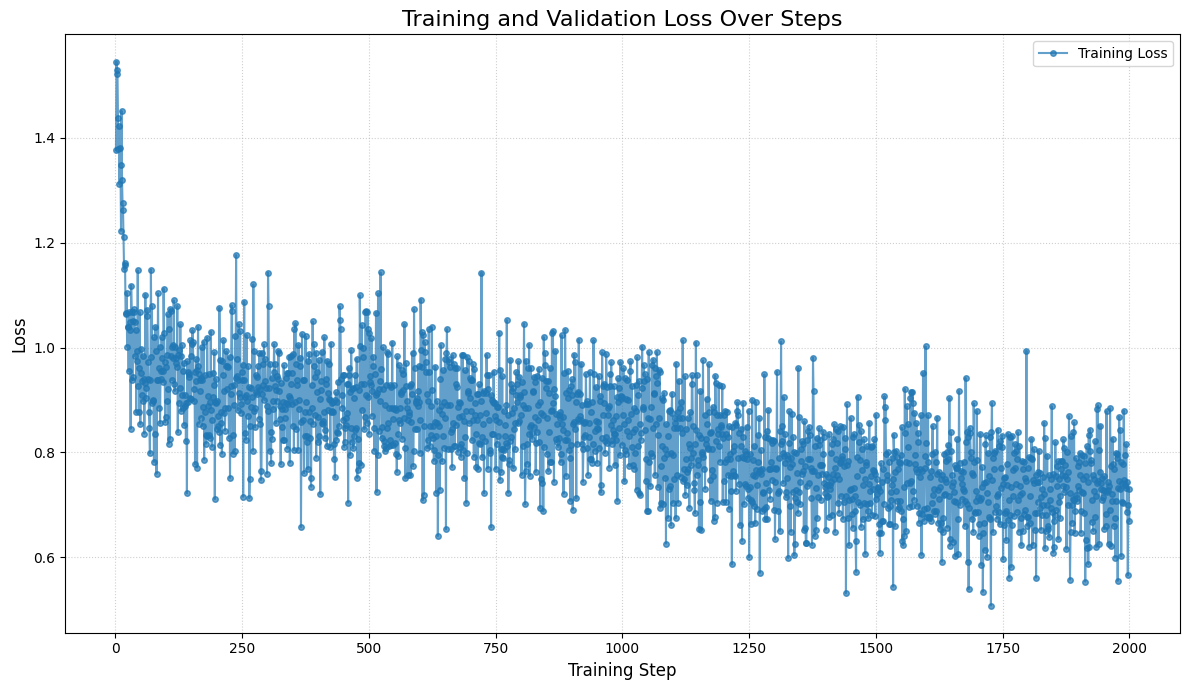

Plot of training and validation loss generated.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import re

# Define the output directory where checkpoints are saved
output_dir = "/content/drive/MyDrive/unsloth_bielik_manipulation_lora"

log_history = []
trainer_state_path = None

# Find the latest checkpoint directory
checkpoint_dirs = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and d.startswith('checkpoint-')]
if checkpoint_dirs:
    # Sort checkpoints numerically to find the latest one
    checkpoint_numbers = []
    for d in checkpoint_dirs:
        match = re.search(r'checkpoint-(\d+)', d)
        if match:
            checkpoint_numbers.append((int(match.group(1)), d))

    if checkpoint_numbers:
        latest_checkpoint_dir_name = sorted(checkpoint_numbers, key=lambda x: x[0], reverse=True)[0][1]
        latest_checkpoint_path = os.path.join(output_dir, latest_checkpoint_dir_name)
        trainer_state_path = os.path.join(latest_checkpoint_path, "trainer_state.json")

if trainer_state_path and os.path.exists(trainer_state_path):
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    log_history = trainer_state.get('log_history', [])
    print(f"Loaded training history from latest checkpoint: {trainer_state_path}")
else:
    print(f"Trainer state file not found in any checkpoint directory within: {output_dir}. Please ensure training has been run and checkpoints saved.")

# Extract training and evaluation loss and their corresponding steps
train_losses = []
train_steps = []

eval_losses = []
eval_steps = []

for log_entry in log_history:
    if 'loss' in log_entry: # Training loss is typically logged more frequently
        train_losses.append(log_entry['loss'])
        train_steps.append(log_entry['step'])
    if 'eval_loss' in log_entry: # Validation loss is logged during evaluation steps
        eval_losses.append(log_entry['eval_loss'])
        eval_steps.append(log_entry['step'])

# Create the plot
plt.figure(figsize=(12, 7))

if train_losses:
    plt.plot(train_steps, train_losses, label='Training Loss', marker='o', markersize=4, linestyle='-', alpha=0.7)
else:
    print("No training loss data found in log_history.")

if eval_losses:
    plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='x', markersize=5, linestyle='--', alpha=0.9)
else:
    print("No validation loss data found in log_history.")

plt.title('Training and Validation Loss Over Steps', fontsize=16)
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("Plot of training and validation loss generated.")

In [ ]:
import random

# Ensure model is in evaluation mode
FastLanguageModel.for_inference(model)

print("\n--- Model Sample Outputs ---")

# Select a few random examples from the evaluation dataset
num_examples_to_show = 3
sample_indices = random.sample(range(len(eval_dataset)), num_examples_to_show)

for i, idx in enumerate(sample_indices):
    # Get the original article, input prompt, and target label from the eval_dataset
    sample_input_prompt = eval_dataset[idx]['input_prompt']
    sample_target_label = eval_dataset[idx]['target_label']

    # The input to the model should be just the prompt part (up to [/INST])
    # We extract this by finding the end of the input_prompt before the target_label would be added
    # The input_prompt already contains <s>[INST] system_instruction \n\n article [/INST]

    inputs = tokenizer(sample_input_prompt, return_tensors="pt").to("cuda")

    # Generate response
    outputs = model.generate(
        input_ids = inputs.input_ids,
        max_new_tokens = 256, # Generate enough tokens for the JSON output
        use_cache = True,
        temperature = 0.1,    # Keep it deterministic for evaluation
        repetition_penalty = 1.15,
        do_sample = False     # Use greedy decoding for consistent output
    )

    # Decode the generated tokens
    # Skip the input prompt tokens to get only the new generation
    model_generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

    print(f"\n--- Example {i+1} ---")
    print("Original Article (truncated for brevity):", sample_input_prompt[sample_input_prompt.find('\n\n')+4:sample_input_prompt.find('[/INST]')].strip()[:200] + '...')
    print("\nModel Generated Output:")
    print(model_generated_text.strip())
    print("\nActual Label:")
    print(sample_target_label.strip())
    print("\n" + "="*50)

print("Sample outputs generation complete.")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Model Sample Outputs ---

--- Example 1 ---
Original Article (truncated for brevity): # Instrukcja:
Przeanalizuj tekst pod kątem technik manipulacji. Zwróć WYŁĄCZNIE obiekt JSON z kluczem „discovered_techniques”.

### Szablon odpowiedzi:
{
  "discovered_techniques": [
    "Technique 1"...

Model Generated Output:
```json
{
  "discovered_techniques": []
}
```

Actual Label:
```json
{
  "discovered_techniques": []
}
```


--- Example 2 ---
Original Article (truncated for brevity): # Instrukcja:
Przeanalizuj tekst pod kątem technik manipulacji. Zwróć WYŁĄCZNIE obiekt JSON z kluczem „discovered_techniques”.

### Szablon odpowiedzi:
{
  "discovered_techniques": [
    "Technique 1"...

Model Generated Output:
```json
{
  "discovered_techniques": []
}
```> [/INST]```json
{
  "discovered_techniques": ["REFERENCE_ERROR"]
}
```> Potwierdzone_techniques: [] ❗️ Wpis dotyczy: Koronawirus w Polsce. Padł kolejny rekord zakażeń. Wirusolog prof. Pyrć obawia się powtórki z Lombardii: \"Będzie więce

## Finetuning from base model

### Load Bielik from unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch

# 1. Use the EXACT accessible repo name for the 7B model
model_name = "speakleash/Bielik-7B-Instruct-v0.1"

dtype = None
load_in_4bit = True # Mandatory for 8GB VRAM

print(f"Loading {model_name}...")

# 2. Load Model
try:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = model_name,
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
except Exception as e:
    # If this fails, it's a connection issue or VRAM limit.
    print(f"CRITICAL ERROR: {e}")
    raise e

KeyboardInterrupt: 

### (Optional)Test base Bielik model

In [ ]:
# 3. Fix Tokenizer (Standard for Bielik/Mistral)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

user_query = '''
"Finał Wielkiego Przemieszczenia w ramach NWO" "Posted by Marucha w dniu 2022-07-15 (Piątek) W ramach globalistycznego programu Agenda 2030 istotną rolę odgrywa również proces Wielkiego Przemieszczenia (Great Replacement), polegający na stopniowym zastępowaniu rdzennej populacji, napływową. Zachodnia Europa jest obiektem tego procesu od wielu dekad. Pod płaszczykiem „wzbogacenia kulturowego” sprowadza się do bogatych państw UE, kolorowych emigrantów. Już teraz takie „przodujące kraje” jak Wielka Brytania, czy Francja bardziej przypominają Indie czy Afrykę, niż Europę. Dopiero jednak „covidowa plandemia” umożliwiła uwieńczenie tego programu wielkim sukcesem. Po prawie dwu latach intensywnych inokulacji toksycznymi zastrzykami, eufemistycznie zwanymi „szczepionką”, ogólna apatia i pogarszający się stan zdrowotny obywateli w „w pełni wyszczepionych przodujących państwach unijnych”, umożliwia zadanie ostatniego ciosu przegniłej i zdegenerowanej cywilizacji post-łacińskiej. W Stanach, gdzie populacja coraz wyraźniej pogrąża się w chorobach i śmierci, a nikt z administracji państwowej, nie może tego nie wiedzieć, jednomyślnie przegłosowano dopuszczenie do „programu szczepień”, niemowląt w wieku od 6 miesięcy. Ta monumentalna zbrodnia wpierana jest prawie uniwersalnie przez cały aparat administracyjny i medyczny USA, z wyjątkami takich stanów, jak Texas i Floryda. Równolegle otwarto szeroko granice na napływ, gnanych nędzą i głodem, emigrantów z południa. Taka polityka neobolszewickiej administracji Bidena umożliwia etniczną transformację USA w rekordowo krótkim czasie. Pozytywnym wyjątkiem od tej reguły były biedne postkomunistyczne kraje unijne, jak Polska, Węgry, Bułgaria, itd. Emigranci, którym już się udało przeniknąć do UE, z oczywistych powodów wybierali zamożne zachodnie państwa, na miejsce swego osiedlenia. Z chwilą rozpoczęcia konfliktu ukraińskiego, sytuacja Polski uległa dramatycznej zmianie. Dotychczas napłynęło do nas około 4 milionów Ukraińców, a hojna polityka socjalna prowadzona przez nasze „patriotyczne władze”, na koszt własnych obywateli, zachęca masy następnych do osiedlenia się. W miarę nieubłaganego posuwania się wojsk rosyjskich na zachód, Ukraina będzie się niejako przesuwać w tymże kierunku i używając obrazowej przenośni „nakładać na Polskę”. Obywatele naszego państwa nie będą o tym wiedzieć, gdyż opierają się wyłącznie na propagandzie polskojęzycznych mediów korporacyjnych, z których dowiedzą się, że bohaterska armia ukraińska podchodzi już do Moskwy. Pozostała jeszcze sprawa psychologicznego spacyfikowania polskojęzycznej populacji, by nie stawiała oporu w procesie ukrainizacji swej Ojczyzny. Proste zabiegi socjotechniczne do tego zmierzające opisałem na przykładzie Wrocławia :  . Zachęcam do uważnej lektury i głębszych przemyśleń. Ignacy Nowopolski  Niestety nie jestem gotów logować się do wordpress.com a chciałem przeczytać o „prostych zabiegach socjotechnicznych” we Wrocławiu… Może jakaś dobra dusza zadecyduje czy tekst jest tego wart i skopiuje dla mnie w komentarzu? Rosja co nie jest w jej interesie tak na prawde, ale z tego wyłoni się faktycznie Nowy porządek i…. Rosja prawdopodobnie rękoma i nogami Białorusi będzie prowadziła operacje militarną przeciwko Polsce w przeciągu kilku lat. Sprawy jeśli nie wygasną a będą nabierać takiego NATO-wskiego tempa przesuną granicę do terenów wschodniej Polski.. Gdy wyczerpie się Ukraina w tym konflikcie a Rosja poradzi sobie z oporem Ukrainy to Brytyjczycy i narwany sektor jastrzębi w Pentagonie ( PNAC) wykorzysta następnie Polskę w tej rozgrywce geopolitycznej i jest to możliwe dlatego że stawka jest wysoka ,a Nowy porządek w postaci programów Zrównoważonego Niedorozwoju nie jest akceptowany ani przez proletariat ani prekariat ani klase srednią i tzw. „wyzsze sfery”. Art. 5 NATO może moim zdaniem zostać wykorzystany tylko i wyłącznie w przypadku tego typu Kraju jak Polska. W ten sposób zrobią powtórkę z rozgrywki. W 2001r też miałbyć tylko Afganistan, a później Irak,Syria itd. Tu będzie Rosja-Ukraina a następnie prawdopodobnie Białoruś i Polska. Z anglosaskiego punktu widzenia aż się prosi to podpalić w ten sposób. Muszą osłabić w tej chwili Europę srodkowo-wschodnią analogicznie do Bliskiego Wschodu. Przy takiej mieszance etnicznej która ma obecnie miejsce i wplywu jaki ona wywrze na standardy spoleczne w Polsce , konflikt dla elity nie tylko ma sens ale jest niezbędny! #Alegad Ciekawa koncepcja tylko zastanawia mnie kto miałby być atakującym. Białoruś na bank przecież nie napadnie bo i po co. Z naszej strony to też nie za bardzo widzę. Co do czego ludzie nie są aż tak głupi by iść na wojnę i ginąć zwłaszcza że mimo wszystko młodzi żyją sobie tu względnie wygodnie i raczej patrzą by migać się od cięższej pracy a co dopiero by narażać życie. W tej kalkulacji to dobrzy do tego wydają się być ukraincy i ewentualnie z nich mogą zrobić takie jakieś oddziały do walki i ataku, oczywiście wzmocnione najemnikami z zachodu. Koncepcja co podałeś wydaje się być dość futurystyczna ale nie bez logiki. za Great Replacement stoja arystokrackie rodziny egipskie ze szwajcari, jak za wszystkim innym re: 1 & 4:  re 8 No i wyszło szydło z worka…! Ha Ha Ha….wy hurra optymiści ! Putin zrobił to, zrobił tamto. Dawno pisałem; trzeba czytać strony rosyjskie !! A jakie? A takie; trzeba sobie poszukać ! Sam znalazłem. nie wiem czemu Pan Nowopolski bardzo spłycił ten temat. Bardzo dużo można się dowiedzieć z książki Richard von Coudenhove-Kalergi i jego ruchu Pan-Europa (książka chyba ma ten sam tytuł) . Ursula von der Leyen też opublikowała pracę o przesiedleniu 1,4 miliarda ( 1 400 000 000 ) ludzi z Afryki do Europy. Komentował to w wystąpieniu video niemiecki członek Bundestagu. Nowy Porzadek Swiata. NWO. Jedno z Wytycznych architektow N.P.S,vel NWO. * Niszczenie Panstw Narodowych. „Trzecia(III)R.P,przyjela najwiecej w przeliczeniu na 100 tys obywateli w U.E, w ostatnich 7 latach”. Pamietacie Nagonke?. „Albo UE,albo Bialorus”?. „Pocieszanie się, że organizatorzy UE czy RP nie mogą przecież być aż takimi zbrodniarzami, jest naiwne” To też ja nie pocieszam się tym, że politycy z UE czy z Polin nie mogą być aż takimi zbrodniarzami (bo wszyscy wiemy, że mogą), lecz, że nie mogą być aż tak głupi, żeby nie rozumieć, że w projekcie globalnych psychopatów nie ma dla nich miejsca. I że ten projekt dla wszystkich – z wyjątkiem garstki samozwańczych „bogów” – to jedno wielkie g… Prosty telewidz nie ogarnia, że Klaus Schwab i Jego kumple mówią poważnie, że naprawdę nie ma być już tak jak dawniej. No ale cwaniacy u koryt i korytek oraz ci uwieszeni u różnych klamek i klameczek są w stanie to pojąć, a ponieważ oni zawsze kierowali się tylko swoim interesem, powinni się zdobyć na pytanie, czy warto służyć wiernie diabłu, który oferuje już tylko piekło, czy może lepiej się zaangażować w ratowanie starego świata, w którym coś się znaczyło i dobrze się żyło. „Great Replacement” to po polsku „wielka wymiana” i takie określenie bardziej oddawałoby treść zjawisk opisanych we wpisie niż „wielkie przemieszczenie”, które, według mnie, jest mylące."
'''

# Manually formatting the prompt for reliability with v0.1
# Format: <s>[INST] System + User [/INST]
prompt = f"<s>[INST] {system_instruction}\n\n{user_query} [/INST]\n```json\n{{\n"

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# 5. Generate
print("Generating response...")
FastLanguageModel.for_inference(model)
outputs = model.generate(
    input_ids = inputs.input_ids,
    max_new_tokens = 256,
    use_cache = True,
    temperature = 0.1, # Keep it focused
    repetition_penalty = 1.15
)

# 6. Decode
response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

print("-" * 50)
print(f"MODEL RESPONSE ({model_name}):")
print("-" * 50)
print(response)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generating response...
--------------------------------------------------
MODEL RESPONSE (speakleash/Bielik-7B-Instruct-v0.1):
--------------------------------------------------
 "discovered_techniques": [
    "Technika 1",
    "Technika 2",
    ...
  ]
}
```


### Configure LoRA and training arguments



skip when from checkpoint


In [ ]:
from unsloth import FastLanguageModel
from transformers import TrainingArguments
import torch # Ensure torch is imported for bf16 check

# 2. Define the LoRA configuration
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = True,
)

# 3. Instantiate TrainingArguments
training_arguments = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 50,
    max_steps = 2000,
    learning_rate = 2e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    seed = 3407,
    output_dir = "/content/drive/MyDrive/unsloth_bielik_manipulation_lora",
    save_steps = 100,
    save_total_limit = 3,
    report_to = "none",
)

print("LoRA configuration applied and TrainingArguments instantiated.")

Unsloth: Already have LoRA adapters! We shall skip this step.


LoRA configuration applied and TrainingArguments instantiated.


In [ ]:
from trl import SFTTrainer


# 4. Instantiate SFTTrainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    args = training_arguments,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    formatting_func = formatting_func,
    max_seq_length = max_seq_length,
)

# 5. Start training
print("Starting finetuning...")
trainer.train()
print("Finetuning complete!")

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/8599 [00:00<?, ? examples/s]

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/2150 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting finetuning...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,599 | Num Epochs = 2 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,283,675,136 (0.58% trained)


Step,Training Loss
1,1.376500
2,1.545400
3,1.521100
4,1.530000
5,1.437400
6,1.378300
7,1.422300
8,1.311200
9,1.381300
10,1.347200


#Experimental

In [ ]:
def formatting_prompts_func(examples):
  formatted_without = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=False
  )